In [1]:
import backtrader as bt
import backtrader.feeds as btfeeds
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
from statsmodels.tsa.stattools import adfuller

from algo.cointegration.augmented_dickey_fuller import print_adf_results
from algo.sde.ornstein_uhlenbeck_optimisation import calc_optimal_ou_params, log_likelihood_ou, loglikelihood_candidates_ou, ou_hedging_parameters


interval = "1h"
test_interval = timedelta(hours=24*7)  # 1 week
train_interval = timedelta(hours=24*7*26)  # 6 months


ticker0 = "BZ=F"
ticker1 = "CL=F"

today = date.today()

# Backtrader needs datetime objects
end_date = today
start_date = today - train_interval

# Yahoo needs strings
end_date_str = end_date.strftime("%Y-%m-%d")
start_date_str = start_date.strftime("%Y-%m-%d")

df0 = yf.download(ticker0, start=start_date_str, end=end_date_str, interval=interval)
df1 = yf.download(ticker1, start=start_date_str, end=end_date_str, interval=interval)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
# Shorten data while testing
# df0 = df0.tail(10)
# df1 = df1.tail(10)

data_path0 = "data/df1.csv"
data_path1 = "data/df2.csv"
df0.to_csv(data_path0)
df1.to_csv(data_path1)

In [3]:
# Number of data points needed to train the initial model
# num_train_initial = 24*7*26  # 6 months
num_train_initial = 24*7*2

# Number of data points to elapse before retraining the model with the original and new data
num_train_ongoing = 24*7

In [4]:
# Important TODOs:
# [] For now we ignore roll costs.
# [] Smooth the price data? Hourly might be ok.
# [] Consider exit if cointegration score is too low.


class OUPairsTradingStrategy(bt.Strategy):

    def __init__(self):
        print(f"Initial Position:\n {self.position}")
        
        # Initial run condtions
        self.model_trained = False  # Check if the model has been trained at least once.
        self.in_market = False  # Check if there is an open position.
        self.count = 0  # Resets
        self.global_count = 0  # Never resets
        
        # Initial OU conditions
        self.alpha = None
        self.beta = None
        
        # Initial time series
        self.S0 = np.array([])  # Asset S0
        self.S1 = np.array([])  # Asset S1
        self.X = np.array([])   # Spread
        
        # Trading Signals
        self.z_entry = 1.0
        self.z_exit = 0.5
        
    def next(self):
        self.count += 1
        self.global_count += 1
        
        # Current prices of asset0 and asset1
        p0 = self.data0.close[0]
        p1 = self.data1.close[0]
        
        # Do nothing if at least 1 data stream has missing data
        if p0 is None:
            print("NaN in data stream 0")
            return
        
        if p1 is None:
            print("NaN in data stream 1")
            return
        
        # Store most recent asset prices
        self.S0 = np.append(self.S0, p0)
        self.S1 = np.append(self.S1, p1)
        
        # Train OU-Model for the first time
        if self.count >= num_train_ongoing and not self.model_trained:
            self.train()
            self.model_trained = True  # Record that the model has been trained at least once
        
        # Do nothing if there has not been enough data to train the model
        if not self.model_trained:
            return
        
        # (Re-)Train OU-Model with updated data as soon as we are not in the market.
        # if self.count >= num_train_ongoing and self.model_trained and not in_market:
        if self.count >= num_train_ongoing and not self.in_market:
            self.train()
            
        # X will have been populated during training
        current_spread = self.alpha*p0 - self.beta*p1
        self.X = np.append(self.X, current_spread)
        
        # Current z_score
        z_score = (current_spread - np.mean(self.X)) / np.std(self.X)
        
        # Determine position
        if z_score <= -self.z_entry and not self.in_market:
            self.long_portfolio()
            self.in_market = True
            
        elif z_score >= self.z_entry and not self.in_market:
            self.short_portfolio()
            self.in_market = True
            
        elif np.abs(z_score) <= self.z_exit:
            self.exit_market()  # exit_short / exit_long ?
            self.in_market = False
        
    def train(self):
        print("Training OU...")
        # Train model
        start = 0.001
        end = 1.0
        num = int(1/start)
        B_candidates = np.linspace(start, end, num)

        A = 1.0
        alpha = A / self.S0[0]
        dt = 1
        log_likelihoods, ou_params_candidates = loglikelihood_candidates_ou(self.S0, self.S1, dt, alpha, B_candidates)
        hp, _ = ou_hedging_parameters(log_likelihoods, ou_params_candidates, B_candidates, S2_0=self.S1[0], A=A, alpha=alpha)

        alpha = hp["alpha"]
        beta = hp["beta"]
        B = hp["B"]
        
        # (Re-)Compute historic spread using (new) hedging parameters
        self.X = alpha*self.S0 - beta*self.S1
        
        # Update alpha, beta for use until the next re-training
        self.alpha = alpha
        self.beta = beta    
        
        # TODO: only trade if cointegration tests pass.
        # ADF Test for cointegration
        adf = adfuller(self.X, maxlag=1)
        print_adf_results(adf)
        
        # Reset counter for ongoing training
        self.count = 0
        
    def long_portfolio(self):
        # Buy asset S0 and sell asset S1
        print(f"{self.global_count} {self.count} LONG PORTFOLIO")
        
        # TODO: A and B?
        qty0 = 1
        qty1 = 2
        
        self.buy(data=self.data0, size=(qty0))
        self.sell(data=self.data1, size=(qty1))
        
    def short_portfolio(self):
        # Sell asset S0 and buy asset S1
        print(f"{self.global_count} {self.count} SHORT PORTFOLIO")
        
        # TODO: A and B?
        qty0 = 1
        qty1 = 2
        
        self.sell(data=self.data0, size=(qty0))
        self.buy(data=self.data1, size=(qty1))
        
        
    def exit_market(self):
        # TODO: close all positions.
        ...

In [5]:
cb = bt.Cerebro()

# Add only the TEST data streams to the engine
data0 = btfeeds.YahooFinanceCSVData(
    dataname=data_path0,
    fromdate=start_date,
    todate=end_date,
)
cb.adddata(data0)

data1 = btfeeds.YahooFinanceCSVData(
    dataname=data_path1,
    fromdate=start_date,
    todate=end_date,
)
cb.adddata(data1)

# Add the trading strategy to the engine
cb.addstrategy(OUPairsTradingStrategy)

# Set starting cash balance
cb.broker.setcash(100.0)

# Percentage commission - broker fees: 0.005 is 0.5%.
cb.broker.setcommission(0.005)

# Initial conditions
print(f"Starting Portfolio Value: {cb.broker.getvalue()}")

cb.run()

# Result
print(f"Final Portfolio Value: {cb.broker.getvalue()}")

Starting Portfolio Value: 100.0
Initial Position:
 --- Position Begin
- Size: 0
- Price: 0.0
- Price orig: 0.0
- Closed: 0
- Opened: 0
- Adjbase: None
--- Position End
Training OU...
Failed to reject the null hypothesis - no cointegration.
168 0 SHORT PORTFOLIO
Training OU...
Failed to reject the null hypothesis - no cointegration.
422 86 SHORT PORTFOLIO
495 159 LONG PORTFOLIO
Training OU...
REJECT the null hypothesis of a unit root in the residuals at the 5% significance level. S1 and S2 are cointegrated.
546 22 LONG PORTFOLIO
556 32 LONG PORTFOLIO
562 38 SHORT PORTFOLIO
651 127 SHORT PORTFOLIO
Training OU...
REJECT the null hypothesis of a unit root in the residuals at the 1% significance level. S1 and S2 are cointegrated.
715 4 LONG PORTFOLIO
763 52 LONG PORTFOLIO
Training OU...
REJECT the null hypothesis of a unit root in the residuals at the 5% significance level. S1 and S2 are cointegrated.
1162 131 SHORT PORTFOLIO
Training OU...
REJECT the null hypothesis of a unit root in the r

In [6]:
# NEED TO SWITCH TO JUPYTER NOTEBOOK FOR THIS TO WORK.
# %matplotlib ipympl
%matplotlib widget
# %matplotlib inline

cb.plot()

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 6 Axes>]]

<IPython.core.display.Javascript object>


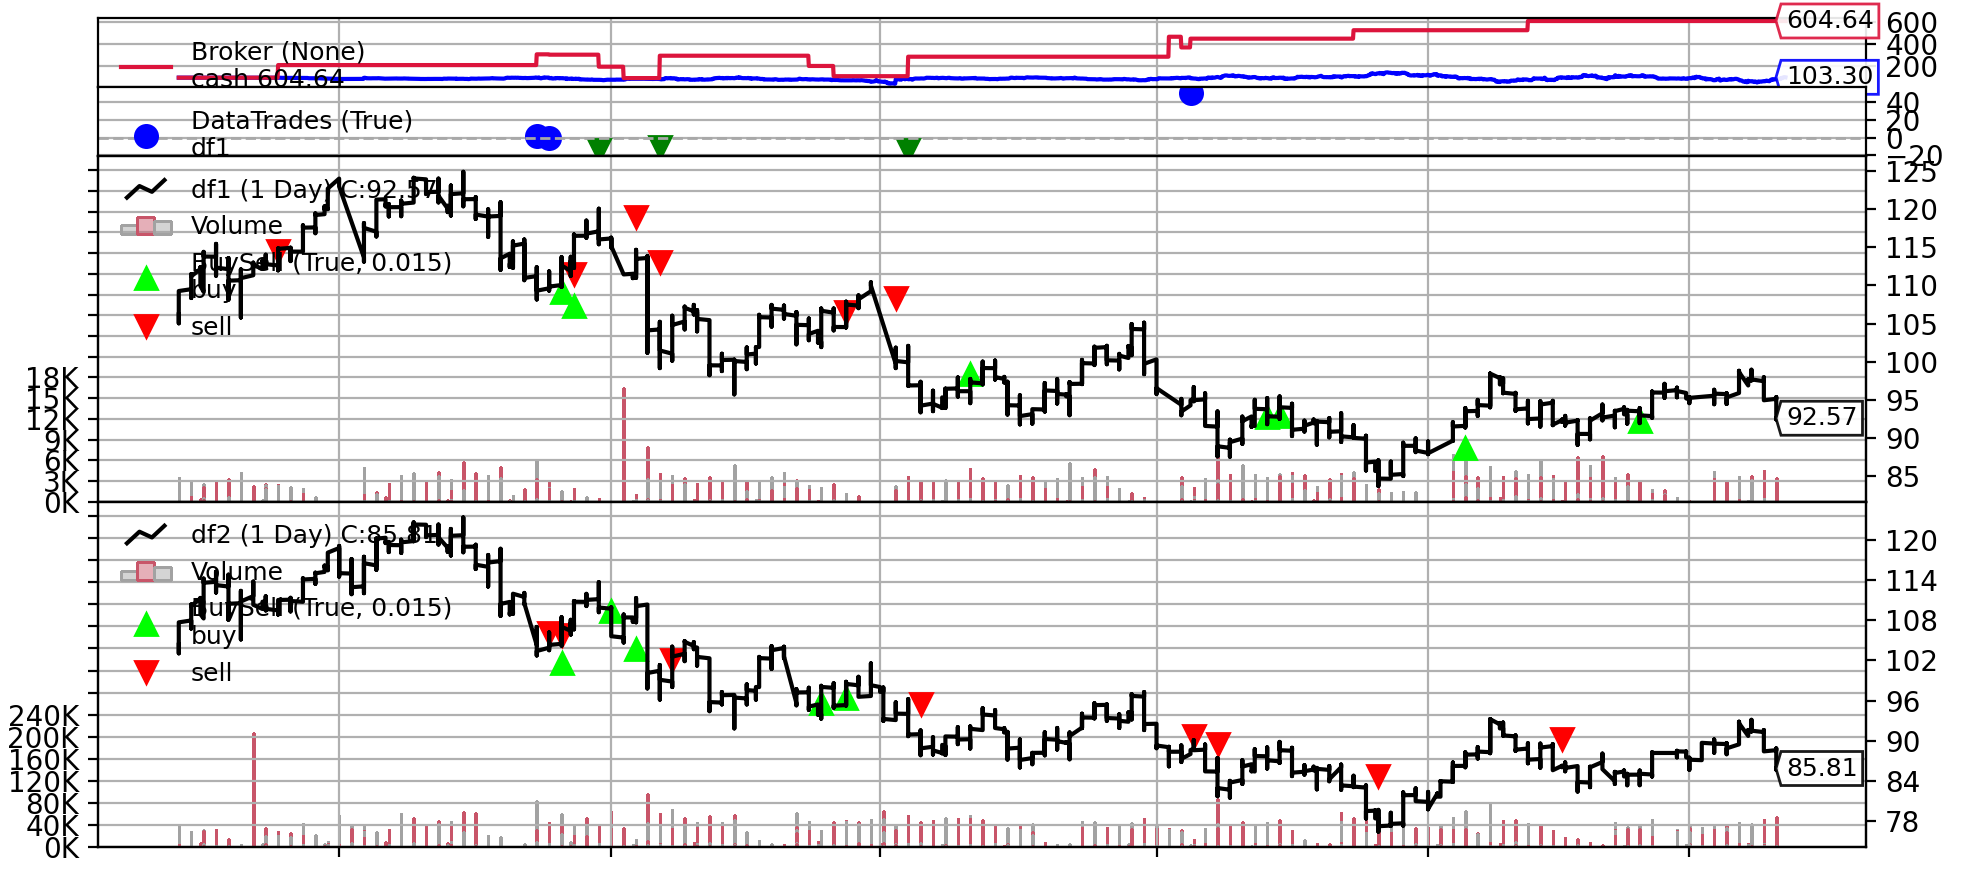

[[<Figure size 640x480 with 6 Axes>]]